In [32]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import ipyparallel as ipp

cluster = ipp.Client()

v = cluster[:]
lview = cluster.load_balanced_view()
len(v)

40

In [38]:
import os

os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1                              #Block multithreading
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

In [39]:
%%px --local

import kwant
import tinyarray
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import scipy.constants as sc
from scipy.constants import physical_constants
from scipy import constants
import numpy as np
import types
import pandas as pd

In [40]:
%%px --local

from cmath import exp
from math import pi
from scipy import constants

In [41]:
%%px --local

c = physical_constants['speed of light in vacuum'][0]
val_hbar = physical_constants['Planck constant over 2 pi in eV s'][0]
val_mu_B = physical_constants['Bohr magneton in eV/T'][0]
val_e = physical_constants['elementary charge'][0]
unit = physical_constants['elementary charge'][1]

val_m0 = physical_constants['electron mass energy equivalent in MeV'][0]
# print(val_e/val_hbar)



In [42]:
%%px --local

s0 = tinyarray.array([[1, 0], [0, 1]])
sx = tinyarray.array([[0, 1], [1, 0]])
sy = tinyarray.array([[0, -1j], [1j, 0]])
sz = tinyarray.array([[1, 0], [0, -1]])
sx1 = tinyarray.array([[0, 1], [0, 0]])
sx2 = tinyarray.array([[0, 0], [1, 0]])

s0sx = np.kron(s0,sx)
s0sy = np.kron(s0,sy)
s0sz = np.kron(s0,sz)
s0sx1  = np.kron(s0,sx1)
s0sx2  = np.kron(s0,sx2)
sxsz  = np.kron(sx,sz)
sysz  = np.kron(sy,sz)



#print(dir(constants))
def make_system(L_W,L_SC,L_N):
         
    a= 5*1e-9
    m = 0.014
    t=val_hbar**2*c**2/(2*m*val_m0*1e6*a**2)
    mu = 10*1e-3
    Delta = 1.0*1e-3




    lat = kwant.lattice.square(a*1e9, norbs=4)
    syst = kwant.Builder()
    
    def wire(pos):
        (x,y) = pos
        
        ret = False
        if (-L_SC -L_N/2  <= x <= L_SC + L_N/2 and -L_W/2<=y<=L_W/2):
            ret = True
        if (-L_N/2< x< L_N/2 and L_W/2<= y <=L_SC):  
            ret = True
            
        return ret

    def onsite(site, phi1,phi2,phi3):
        (x,y) = site.pos
        
        if (-L_W/2<=y<=L_W/2 and  x <= -L_N/2):
             return  (4 * t - mu) *  s0sz + Delta  * exp(1j * phi1) * s0sx1 + Delta  * exp(-1j * phi1) * s0sx2
        if (-L_W/2<=y<=L_W/2 and  x >= L_N/2):
             return (4 * t - mu) *  s0sz + Delta  * exp(1j * phi2) * s0sx1 + Delta  * exp(-1j * phi2) * s0sx2
        if -L_N/2< x< L_N/2 and L_W/2< y <=L_SC:
            return (4 * t - mu) *  s0sz + Delta  * exp(1j * phi3) * s0sx1 + Delta  * exp(-1j * phi3) * s0sx2
            
        else:
            return (4 * t - mu) *  s0sz
    
    def hopx(site1 ,site2, alpha):
           return -t * s0sz + 1j * alpha * sysz / (2*a*1e9)
    
    def hopy(site1 ,site2, alpha):
          return -t * s0sz  - 1j * alpha * sxsz / (2*a*1e9)
    

    syst[lat.shape(wire, (0, 0))] = onsite
    syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = hopx
    syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = hopy

   
   
    return syst




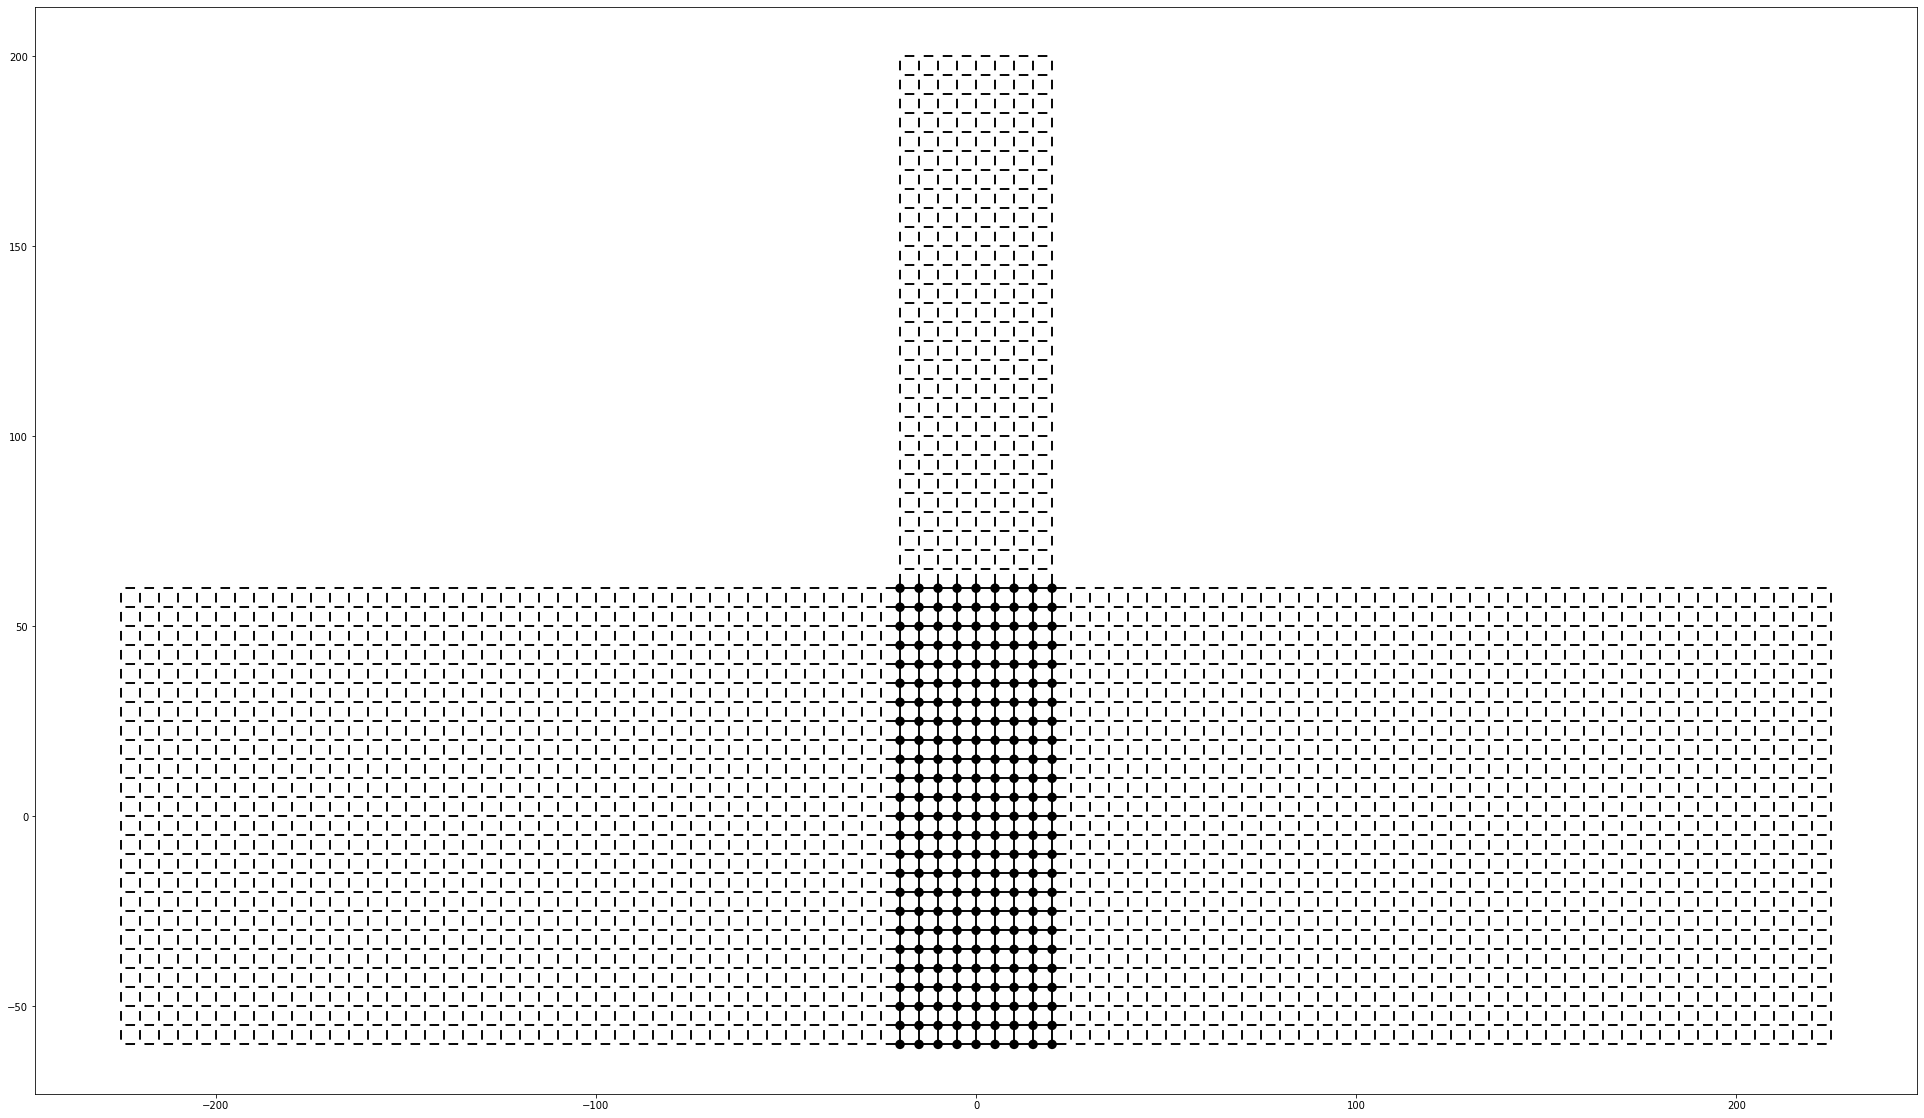

In [43]:
syst = make_system(L_W=120, L_SC=200,L_N=50)
syst = syst.finalized()
kwant.plotter.plot(syst, fig_size = (40,20), colorbar = False,\
                     site_color= lambda site: np.real(syst.hamiltonian(site, site, params = dict(phi1=0, phi2=0, phi3=0, alpha=0.05))[1,0]),\
                     );
#kwant.plot(syst,fig_size = (20,20));
#plt.savefig('SNS_close.pdf',bbox_inches='tight')



In [44]:
#%%px --local
def coherence_length(m, mu, Delta):
    
    """ Calculate the coherence lenght of the josephson junction
    m: value of effective mass in terms of the electron mass (This has to express in MeV/c**2)
    Delta : Superconducting gap
    mu : Chemical potential  """
    
    val_m0 = physical_constants['electron mass energy equivalent in MeV'][0]
    val_hbar = physical_constants['Planck constant over 2 pi in eV s'][0]
    c= physical_constants['speed of light in vacuum'][0]
    vf = np.sqrt(2*mu*c**2/(m*val_m0*1e6))
    xi = val_hbar*vf/Delta
    xi = xi*1e9 #If we want to express in nm we multiply by *1e9
    
    return xi, val_hbar

In [45]:
m = 0.014
mu = 10*1e-3
Delta = 1.0*1e-3
print("Coherence length = ", coherence_length(m, mu, Delta))

Coherence length =  (329.9342814156751, 6.582119514e-16)


In [47]:
%%px --local
def calculate_energies(phi2,phi3,phi1,L_W,L_SC, L_N,alpha,n_values):
        """Compute eigenenergies using MUMPS as a sparse solver.

        Parameters:
        ----------
        ham : coo_matrix
            The Hamiltonian of the system in sparse representation..
        n_eigs : int
            The number of energy eigenvalues to be returned.
        n_vec_lanczos : int
            Number of Lanczos vectors used by the sparse solver.
        sigma : float
            Parameter used by the shift-inverted method. See
            documentation of scipy.sparse.linalg.eig

        Returns:
        --------
        A list containing the sorted energy levels. Only positive
        energies are returned.
        """
        class LuInv(sla.LinearOperator):
            def __init__(self, A):
                inst = kwant.linalg.mumps.MUMPSContext()
                inst.factor(A, ordering='metis')
                self.solve = inst.solve
                try:
                    super(LuInv, self).__init__(shape=A.shape, dtype=A.dtype,
                                                matvec=self._matvec)
                except TypeError:
                    super(LuInv, self).__init__(shape=A.shape, dtype=A.dtype)

            def _matvec(self, x):
                return self.solve(x.astype(self.dtype))

        n_eigs=n_values
        n_vec_lanczos=3*n_values+10
        sigma=0.0
        
        syst = make_system(L_W=L_W, L_SC=L_SC,L_N= L_N).finalized()
        ham_mat = syst.hamiltonian_submatrix(params=dict(phi1=phi1, phi2=phi2, phi3=phi3, alpha=alpha), sparse=True)
        ev = sla.eigs(ham_mat, k=n_eigs, OPinv=LuInv(ham_mat), sigma=sigma, ncv=n_vec_lanczos,\
                      return_eigenvectors=False)
        energies = np.sort(ev)
        
        
        
        return energies[energies>0]

In [48]:
def efficiency_eigenstates(phi1,phi3, L_W, L_SC, L_N, alpha, n_values):
    
    values=100
    phi2_values = np.linspace(0, 2 * np.pi, 100)
    ABStab= []
    
    energy = lview.map_async(lambda phi2 : calculate_energies(phi2, phi1 =phi1, phi3=phi3, L_W=L_W, L_SC=L_SC,\
                                                       L_N=L_N, alpha=alpha, n_values=n_values), phi2_values)
    
    energy.wait_interactive()
    energies = energy.get()
    
    energies1 = np.array(np.real(energies))
    
    for i in range(values):
        ABStab.append(np.sum(energies1[i,:]))
    I = -np.gradient(ABStab,phi2_values)#axis=0)

    
    Delta=1.0*1e-3

    maximum =  (max(I)/Delta)
    minimum =  (min(I)/Delta)
    print('The maximum value of I is', maximum)
    print('The minimum value of I is ', minimum)
    print('Current difference:', abs(maximum - abs(minimum)))
    
    n = (maximum - abs(minimum))/(maximum + abs(minimum))

    return  np.array(energies1)*1e3, I/Delta, n*100
    

In [49]:
energies_current_nvalues500 = efficiency_eigenstates(phi1 =0, phi3=1.5*np.pi, L_W=500, L_SC=1000,L_N=500, alpha=0.0,n_values=500)

 100/100 tasks finished after 11230 s
done
The maximum value of I is 2.198714517391842
The minimum value of I is  -2.694737745410958
Current difference: 0.4960232280191157


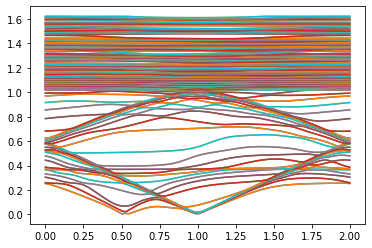

In [50]:
phi2_values = np.linspace(0, 2 * np.pi, 100)
plt.plot(phi2_values/np.pi,energies_current_nvalues500[0])
plt.show()

/tmp/ipykernel_903553/1192468668.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot( rows, cols, 1, facecolor="lightcyan")
/tmp/ipykernel_903553/1192468668.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot( rows, cols, 1, facecolor="white")
/tmp/ipykernel_903553/1192468668.py:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot( rows, cols, 2, facecolor="white")


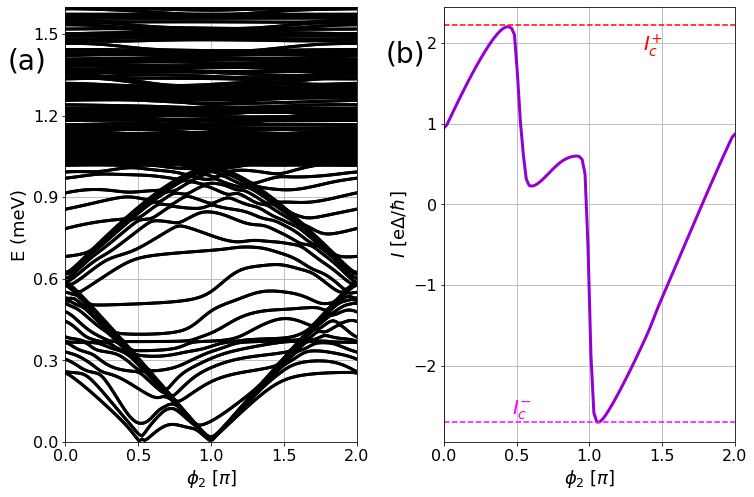

In [76]:
#fig.subplots_adjust(hspace=0.05, wspace=0.25)
Delta = 0.2*1e-3
phase2 = np.linspace(0, 2*np.pi, 100)
rows, cols = 1, 2
f, axs = plt.subplots( rows, cols,figsize=(12, 8))
plt.subplot( rows, cols, 1, facecolor="lightcyan")
plt.subplots_adjust(wspace=0.3, hspace=0.1)
#f.tight_layout()

#plt.subplot(2, 2, 1)

plt.subplot( rows, cols, 1, facecolor="white")
#frame1.axes.xaxis.set_ticklabels([])

#frame1 = plt.gca()

plt.plot(phi2_values/np.pi,energies_current_nvalues500[0], lw=3, color='black')
#plt.plot(phi2_values/np.pi, y2, lw=2.5, color= 'blue',label ='$\phi_3 = 1.5\pi$')
#plt.legend(fontsize=14,loc=4)

plt.xlabel("$\phi_2\;[\pi]$",fontsize=18)
plt.ylabel("E (meV)",fontsize=18)
plt.xticks(np.arange(min(phase2/np.pi), max(phase2/np.pi)+0.5, 0.5), fontsize = 16)
plt.yticks(np.arange(0.0, np.max(np.real(energies_current_nvalues500[0]))+0.5, 0.3), fontsize = 16)
#plt.yticks(fontsize=16)
#plt.xticks(np.arange(min(phi2_values/np.pi), max(phi2_values/np.pi)+0.5, 0.5), fontsize = 16)
plt.text(-0.4, 1.37, "(a)", fontsize=28)
plt.xlim(0,2)
plt.ylim(0,1.6)
#plt.text(0.1, 0.022, "(a)", fontsize=24)
#plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))


plt.grid()


# plt.subplot(2, 2, 2)
plt.subplot( rows, cols, 2, facecolor="white")
#frame2.axes.xaxis.set_ticklabels([])

#frame2 = plt.gca()

plt.plot(phi2_values/np.pi,energies_current_nvalues500[1],color="darkviolet",lw=3)

plt.xlabel("$\phi_2\;[\pi]$",fontsize=18)
plt.ylabel("$\mathit{I}$ [e$\Delta$/$\hbar$]", fontsize=18)
plt.xticks(np.arange(min(phase2/np.pi), max(phase2/np.pi)+0.5, 0.5), fontsize = 16)
plt.yticks(fontsize=16)

plt.xlim(0,2)
plt.axhline(y=2.22, color='r', linestyle='--')#, label="$I^{+}_c$")
plt.axhline(y=-2.7, color='magenta', linestyle='--')#, label="$I^{-}_c$")
plt.text(1.5, 1.8, '$I^{+}_c$', color='r', fontsize=20, ha='right', va='bottom')
plt.text(0.6, -2.4, '$I^{-}_c$', color='magenta', fontsize=20, ha='right', va='top')
plt.text(-0.4, 1.76, "(b)", fontsize=28)



plt.grid()
plt.savefig("energies_current_longjunction.pdf",bbox_inches ="tight")

plt.show()

In [52]:
energies_current_nvalues500[2]

-10.13646810840678

# Efficiency long junction

In [47]:
# %%px --local
def current(phi1,phi3, L_W, L_SC, L_N, alpha, n_values):
    
    values=100
    phi2_values = np.linspace(0, 2 * np.pi, values)
    ABStab= []
    
    energy = lview.map_async(lambda phi2 : calculate_energies(phi2, phi1 =phi1, phi3=phi3, L_W=L_W, L_SC=L_SC,\
                                                       L_N=L_N, alpha=alpha, n_values=n_values), phi2_values)
    
    energy.wait_interactive()
    energies = energy.get()
    
    energies1 = np.array(np.real(energies))
    
    for i in range(values):
        ABStab.append(np.sum(energies1[i,:]))
    I = -np.gradient(ABStab,phi2_values)

    return  I

In [48]:
def efficiency(phi1, L_W, L_SC,L_N, alpha, n_values):
    phase3 = np.linspace(0, 2*np.pi, 100)
    maximum =[]
    minimum =[]
    efficiency =[]
    Delta = 1.0*1e-3

    for phi3 in phase3:

        corrientes = current(phi1=phi1,phi3=phi3, L_W=L_W, L_SC=L_SC, L_N=L_N, alpha=alpha, n_values=n_values)

        maxi = np.max(corrientes)
        mini = np.min(corrientes)

        n = (maxi - abs(mini))/(maxi + abs(mini))

        maximum.append(maxi)
        minimum.append(mini)

        efficiency.append(n)

    return np.array(maximum)/Delta, np.array(minimum)/Delta, np.array(efficiency)*100
    

In [ ]:
valores_efficiency = efficiency(phi1=0, L_W=500, L_SC=1000, L_N=500, alpha=0.0, n_values=500)

   0/100 tasks finished after 1230 s

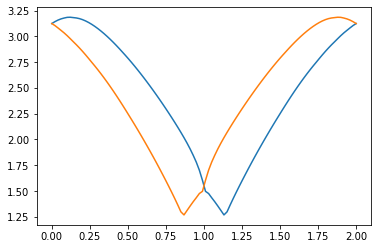

In [56]:
phase3 = np.linspace(0, 2*np.pi, 100)
plt.plot(phase3/np.pi,valores_efficiency[0])
plt.plot(phase3/np.pi,abs(valores_efficiency[1]))

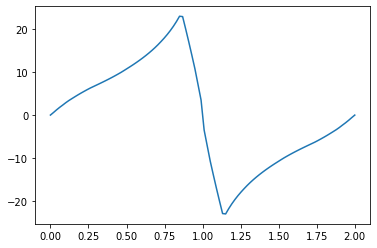

In [58]:
plt.plot(phase3/np.pi, valores_efficiency[2])

In [64]:
maximum = valores_efficiency[0]
minimum = valores_efficiency[1]
efficiency = valores_efficiency[2]

/tmp/ipykernel_771733/690049078.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


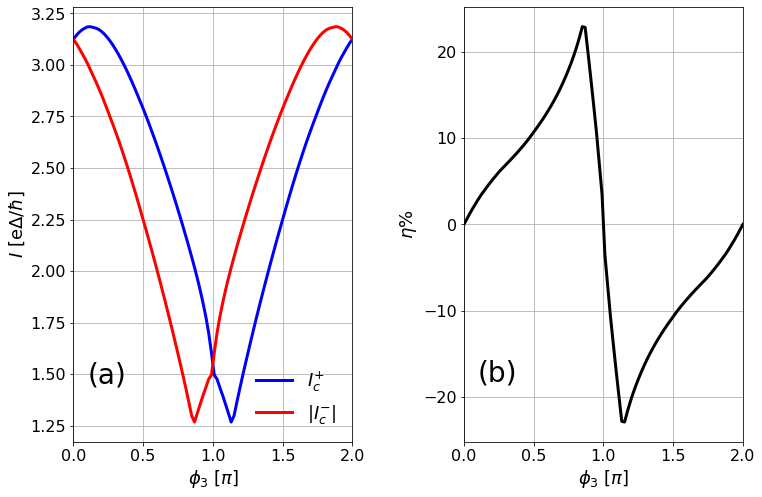

In [96]:
fig =plt.figure(1,figsize=(12,8))#cambio de tamaño del area de ploteo (x, y)
fig.subplots_adjust(hspace=0.15, wspace=0.4)

frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
#     frame1.axes.yaxis.set_ticklabels([])
phase3 = np.linspace(0, 2*np.pi, 100)
plt.subplot(1, 2, 1)
plt.plot(phase3/np.pi, np.array(maximum), label='$I^{+}_c$', lw = 3, color='blue')
plt.plot(phase3/np.pi, np.abs(np.array(minimum)), label='$|I^{-}_c|$', lw = 3, color= 'red')
plt.xlabel("$\phi_3\;[\pi]$", fontsize=18)    
plt.ylabel("$\mathit{I}$ [e$\Delta$/$\hbar$]", fontsize=18)
plt.xlim(0,2)
plt.xticks(np.arange(min(phase3/np.pi), max(phase3/np.pi)+0.5, 0.5), fontsize = 16)
plt.yticks(fontsize = 16)
plt.text(0.1, 1.455, "(a)", fontsize=28)
plt.legend(frameon=False,loc='lower right',fontsize=18)

# inclination_angle = 0 
# plt.annotate("$I^{+}_c$", fontsize=18, xy=(0.7, 20.5), xytext=(1.1, 18),
#             arrowprops=dict(arrowstyle='->'))
# plt.annotate('$I^{-}_c$',fontsize=18, xy=(1.2, -18.6), xytext=(1.1, -15),
#             arrowprops=dict(arrowstyle='->'))
plt.grid()

#plot 2:
plt.subplot(1, 2, 2)
plt.plot(phase3/np.pi,np.array(efficiency), lw = 3, color='black')
#plt.plot(phase3/np.pi,np.array(efficiency)*100, lw = 3, color='black')

plt.xlabel("$\phi_3\;[\pi]$", fontsize=18)
plt.ylabel("$\eta$%", fontsize=18)
plt.xlim(0,2)
plt.xticks(np.arange(min(phase3/np.pi), max(phase3/np.pi)+0.5, 0.5), fontsize = 16)
plt.yticks(fontsize = 16)
plt.text(0.1, -18.2, "(b)", fontsize=28)

plt.grid()

plt.savefig("supercurrent_efficiency_longjunction.pdf",bbox_inches ="tight")

plt.show();


In [ ]:
import pandas as pd

In [73]:
pd.DataFrame(maximum).to_pickle('/home/jhcorrea/data_long_junction/maximum_friday151223.pkl')    #to save the dataframe, df to *.pkl\
pd.DataFrame(minimum).to_pickle('/home/jhcorrea/data_long_junction/minimum_friday151223.pkl')    #to save the dataframe, df to *.pkl\
pd.DataFrame(efficiency).to_pickle('/home/jhcorrea/data_long_junction/efficiency_friday151223.pkl')    #to save the dataframe, df to *.pkl\